# Import packages

In [1]:
import wfdb
import bchlib
import sqlite3
import itertools
import numpy as np
from enum import Enum
from audiolazy import lazy_lpc
import matplotlib.pyplot as plt
from dataclasses import dataclass
import scipy.signal, scipy.fftpack
from typing import Callable, Generator, Optional, Union

In [2]:
Number = Union[int, float]

In [3]:
record_names = (*[name.strip('\n') for name in open('../data/mit-bih-normal-sinus-rhythm-database-1.0.0/RECORDS', 'r')],)
last_beat_locations = (10247936, 10802693, 9516612, 9953468, 9740719, 10837734, 10002106, 10758639, 9566042, 
                    9779185, 9533735, 10355616, 9629397, 9294493, 8861963, 9246278, 9220939, 9723469)

In [4]:
class Record:
    """
    This class is responsible for wrapping around the wfdb.record object. It is designed to provide 
    easy access to the signal data and other useful parts of wfdb.record object.
    """
    def __init__(self, path: str, sample_from: int = 0, sample_to: Union[int, None] = None,
                 channels: Union[list, None] = None, use_physical: bool = True):
        """
        Construct a new Record object.
        :param path: relative path to the record to be loaded.
        :param sample_from: where should the sampling of the record begin from.
        :param sample_to: where should the sample of the record end at.
        :param channels: which channels should be loaded.
        :param use_physical: should the phyiscal or digital values be loaded. 
        """
        self._path = path
        self._sample_from = sample_from
        self._sample_to = sample_to
        self._channels = channels
        self._use_physical = use_physical
        self._data = wfdb.rdrecord(path, sample_from, sample_to, channels, use_physical)
        
    @property
    def path(self) -> str:
        return self._path
    
    @property
    def name(self) -> str:
        return self.data.record_name
    
    @property
    def sample_from(self) -> int:
        return self._sample_from
    
    @property
    def sample_to(self) -> int:
        return self._sample_to
    
    @property
    def duration(self) -> int:
        return self.data.sig_len
    
    @property
    def channels(self) -> list:
        return self._channels
    
    @property
    def use_physical(self) -> bool:
        return self._use_physical
    
    @property
    def data(self) -> wfdb.Record:
        return self._data
    
    @property
    def channel_names(self) -> tuple:
        return (*self.data.sig_name,)
    
    @property
    def channel_count(self) -> int:
        return len(self.channel_names)
    
    @property
    def channel_units(self) -> tuple:
        return (*self.data.units,)
    
    @property
    def sample_rate(self) -> int:
        return self.data.fs
    
    def extract_channel(self, channel_index: int) -> np.ndarray:
        """
        Extract a single channel of either the physical or digital values from the record.
        :param channel_index: which channel to extract.
        :return: ndarray containing the extracted channel.
        """
        result: Union[np.ndarray, None] = None
        if self.use_physical:
            try:
                result = np.copy(self.data.p_signal[:, channel_index])
            except IndexError as error:
                raise error
        else:
            try:
                result = np.copy(self.data.d_signal[:, channel_index])
            except IndexError as error:
                raise error
        return result

    def __getitem__(self, key: Union[str, int]) -> np.ndarray:
        """
        Override the [] operator to allow for easy access when extracting the channels.
        :param key: the index or the name of the channel to extract.
        :return: ndarray containing the extracted channel.
        """
        channel_index: int = self.channel_names.index(key) if isinstance(key, str) else key
        return self.extract_channel(channel_index)
    
    def __str__(self) -> str:
        """Human friendly representation of the class as a string."""
        return (f'Record Name: {self.name}, Record Path: {self.path}, Sample From: {self.sample_from}, '
                f'Sample To: {self.sample_to}, Duration: {self.duration}, Channel Names: {self.channel_names}, '
                f'Uses Physical: {self.use_physical}')

In [5]:
class Code(Enum):
    """
    This enum represent the possible annotations contained within the patient's annotation file.
    """
    NORMAL:   str = 'N'
    LBBB:     str = 'L'
    RBBB:     str = 'R'
    BBB:      str = 'B'
    APC:      str = 'A'
    ABERR:    str = 'a'
    NPC:      str = 'J'
    SVPB:     str = 'S'
    PVC:      str = 'V'
    RONT:     str = 'r'
    FUSION:   str = 'F'
    AESC:     str = 'e'
    NESC:     str = 'j'
    SVESC:    str = 'n'
    VESC:     str = 'E'
    PACE:     str = '/'
    PFUS:     str = 'f'
    UNKNOWN:  str = 'Q'
    LEARN:    str = '?'
    VFON:     str = '['
    FLWAV:    str = '!'
    VFOFF:    str = ']'
    NAPC:     str = 'x'
    WFON:     str = '('
    WFOFF:    str = ')'
    PWAVE:    str = 'p'
    TWAVE:    str = 't'
    UWAVE:    str = 'u'
    PQ:       str = '‘'
    JPT:      str = '’'
    PACESP:   str = '^'
    ARFCT:    str = '|'
    NOISE:    str = '~'
    RHYTHM:   str = '+'
    STCH:     str = 's'
    TCH:      str = 'T'
    SYSTOLE:  str = '*'
    DIASTOLE: str = 'D'
    MEASURE:  str = '='
    NOTE:     str = '"'
    LINK:     str = '@'
        
    def __str__(self) -> str:
        """Human friendly representation of the class as a string."""
        return f'{self.name} \'{self.value}\''

In [6]:
class Annotations:
    """
    This class is responsible for wrapping around the wfdb.annotations object.
    It is designed to provide easy access to the annotations locations and their symbols.
    """
    def __init__(self, path: str, sample_from: int = 0, 
                 sample_to: Union[int, None] = None, extension: str = 'atr'):
        """
        Construct a new Annotations object.
        :param path: relative path to the record to be loaded.
        :param sample_from: where should the sampling of the record begin from.
        :param sample_to: where should the sample of the record end at.
        :param extension: file extension of the annotation to be loaded.
        """
        self._path = path
        self._sample_from = sample_from
        self._sample_to = sample_to
        self._extension = extension
        self._data = wfdb.rdann(path, extension, sample_from, sample_to)
    
    @property
    def path(self):
        return self._path
    
    @property
    def name(self) -> str:
        return self.data.record_name
    
    @property 
    def sample_from(self) -> int:
        return self._sample_from
    
    @property
    def sample_to(self) -> int:
        return self._sample_to
    
    @property
    def extension(self) -> str:
        return self._extension
    
    @property
    def data(self) -> wfdb.Record:
        return self._data
    
    @property
    def locations(self) -> tuple:
        return (*self.data.sample,)
    
    @property
    def symbols(self) -> tuple:
        return (*map(Code, self.data.symbol),)
    
    @property
    def locations_and_symbols(self) -> zip:
        return zip(self.locations, self.symbols)
    
    def __str__(self) -> str:
        """Human friendly representation of the class as a string."""
        return (f'Record Name: {self.name}, Record Path: {self.path}, Extension: {self.extension}, '
                f'Sample From: {self.sample_from}, Sample To: {self.sample_to}')

In [7]:
def location_of_last_beat(path: str) -> Union[int, None]:
    """
    Identify the location of the last normal beat within the specified patient record.
    :param path: :param path: relative path to the record to be loaded.
    :return: either None or the sample point at which the last normal beat occurred.
    """
    loc_and_sym: tuple = (*Annotations(path).locations_and_symbols,)
    for location, symbol in reversed(loc_and_sym):
        if symbol is Code.NORMAL:
            return int(location)
    return None

In [8]:
def median_filter(data: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    """
    Perform a median filter against the supplied array of data. Can supply custom kernel size.
    :param data: array of data to be filtered.
    :param kernel_size: size of kernel or window that will slide across the data.
    :return: new ndarray of filtered data. 
    """
    return scipy.signal.medfilt(data, kernel_size)


def auto_correlation(data: np.ndarray, normalise: bool = True) -> np.ndarray:
    """
    Compute the full auto correlation of the provided data. Will normalise the result by default.
    See numpy.correlate for implementation details.
    :param data: input data for which the auto correlation will computed over.
    :param normalise: boolean to determine if the auto correlation should be returned normalised.
    :return: auto correlation of the provided data array.
    """
    coefficients = np.correlate(data, data, 'full')
    return coefficients / coefficients[data.size - 1] if normalise == True else coefficients


def cosine_transformation(data: np.ndarray) -> np.ndarray:
    """
    Perform the discrete cosine transformation over the provided data.
    See scipy.fftpack.dct for implementation details. Custom scaling has been applied.
    See http://cs.uccs.edu/~cs525/video/dctKhayam.pdf for equation definition.
    :param data: input data for which the dct will be computed for.
    :return: dct coefficients.
    """
    coefficients = scipy.fftpack.dct(data) / 2
    for index, coefficient in enumerate(coefficients):
        if index == 0:
            coefficients[index] = np.sqrt(1 / data.size) * coefficient
        else:
            coefficients[index] = np.sqrt(2 / data.size) * coefficient
    return coefficients

In [9]:
def extract_signal_features(signal: np.ndarray):
    """
    Extract the signal features as defined by the ELPA key generation and agreement scheme.
    :param signal: signal which contains features to be extracted.
    :return: tuple containing extracted signal features. 
    """
    correlation_coefficients = auto_correlation(signal)
    l_coefficients = correlation_coefficients[signal.size - 1:]
    consine_coefficients = cosine_transformation(l_coefficients)
    return (correlation_coefficients, l_coefficients, consine_coefficients)

In [10]:
def predict_consine_coefficients(cosine_coefficients: np.ndarray, prediction_coefficients: Optional[np.ndarray] = None):
    """
    Predict the cosine coefficients using the linear prediction coding method. 
    If no prediction cofficients are provided then some are generated and returned.
    :param cosine_coefficients: cosine coefficients to be predicted.
    :param prediction_coefficients: optional linear predicition coefficients that.
    :return: both the prediction result and the prediction coefficients used.
    """
    if not prediction_coefficients:
        prediction_coefficients = lazy_lpc.lpc(cosine_coefficients, order=4).zeros
    prediction = abs(scipy.signal.lfilter(prediction_coefficients, [1], cosine_coefficients))
    return prediction, prediction_coefficients

In [11]:
def convert_prediction_into_key(original: np.ndarray, prediction: np.ndarray):
    """
    Convert the prediction into a key using the pulse code train.
    :param original: the original cosine coefficient array.
    :param prediction: the predicted cosine coefficient array.
    :return: tuple containing key encoded as binary (integer either 1 or 0) and as the errors that is originates from. 
    """
    calculate_errors = lambda original_element, prediction_element: original_element - prediction_element
    pulse_code_train = lambda err: 1 if err >= 0 else 0
    errors = (*map(calculate_errors, original, prediction),)
    key = (*(map(pulse_code_train, errors)),)
    return (key, errors)

In [12]:
def perform_key_agreement(lead_i: np.ndarray, lead_ii: np.ndarray, bch, kernel_size: int = 9):
    """
    Perform the ELPA key generation and agreement method.
    :param lead_i: ECG data originating from the 'sender' in the scheme or alice.
    :param lead_ii: ECG data originating from the 'receiver' in this scheme or bob'.
    :param bch: BCH lib instance.
    :param kernel_size: the size of kernel used in the median filter.
    :return: tuple containing key, lead_ii errors and lead_ii bit flips. 
    """
    lead_i = median_filter(lead_i, kernel_size)
    lead_ii = median_filter(lead_ii, kernel_size)
    lead_i_features = extract_signal_features(lead_i)
    lead_ii_features = extract_signal_features(lead_ii)
    lead_i_prediction, prediction_coefficients = predict_consine_coefficients(lead_i_features[-1])
    lead_ii_prediction, _ = predict_consine_coefficients(lead_ii_features[-1], prediction_coefficients)
    lead_i_key, lead_i_key_errors = convert_prediction_into_key(lead_i_features[-1][:128], lead_i_prediction[:128])
    lead_ii_key, lead_ii_key_errors = convert_prediction_into_key(lead_ii_features[-1][:128], lead_ii_prediction[:128])
    lead_i_key_as_bytes = bytearray(lead_i_key)
    lead_ii_key_as_bytes = bytearray(lead_ii_key)
    error_correction_codes = bch.encode(lead_i_key_as_bytes)
    lead_ii_bit_flips, _, _ = bch.decode(lead_ii_key_as_bytes, error_correction_codes)
    return (lead_i_key, lead_i_key_errors, error_correction_codes, prediction_coefficients, lead_ii_key, lead_ii_key_errors, lead_ii_bit_flips)

In [13]:
def perform_attack(bch, error_correction_codes, prediction_coefficients, attack_signal: np.ndarray, kernel_size: int = 9):
    attack_signal = median_filter(attack_signal, kernel_size)
    attack_features = extract_signal_features(attack_signal)
    attack_predictions, _ = predict_consine_coefficients(attack_features[-1], prediction_coefficients)
    attack_key, attack_errors = convert_prediction_into_key(attack_features[-1][:128], attack_predictions[:128])
    attack_key_as_bytes = bytearray(attack_key)
    attack_bit_flips, _, _ = bch.decode(attack_key_as_bytes, error_correction_codes)
    return (attack_key, attack_errors, attack_bit_flips)

In [14]:
def locate_normal_beats(annotations: Annotations, sample_from: int, sample_to: int, skew_offset: int = 2):
    """
    Identify all of the normal beats within the patient record file.
    :param annotations: annotations which contain the location of all beats normal or otherwise.
    :param sample_from: where should the sampling of the record begin from.
    :param sample_to: where should the sample of the record end at.
    :param skew_offset: apply offset to compensate for skew between record and annotation.
    :return: tuple containing all of the located normal beats.
    """
    return (*((location + skew_offset) - sample_from for location, code 
              in annotations.locations_and_symbols if location >= sample_from and location <= sample_to and code is Code.NORMAL),)

In [15]:
def is_valid(annotations: Annotations, sample_from: int, sample_to: int) -> bool:
    """
    Determine if the provided range of samples is valid for use within the experiments.
    :param annotations: annotations which contain the location of all beats normal or otherwise.
    :param sample_from: where should the sampling of the record begin from.
    :param sample_to: where should the sample of the record end at.
    :return: bool stating if it is valid of not. 
    """
    locations = [location for location in annotations.locations if location >= sample_from and location <= sample_to]
    symbols = [symbol for location, symbol in annotations.locations_and_symbols if location in locations]
    return all(symbol == Code.NORMAL for symbol in symbols)

In [16]:
def extract_compl(signal: np.ndarray, location_of_normal_beat: tuple, n_samples: int = 30) -> np.ndarray:
    """
    Extract a single QRS complex that can identified from the normal beat locations.
    :param signal: the signal data in which the QRS complex shall be extracted from.
    :param location_of_normal_beat: tuple containing the location of normal beats within the signal.
    :param n_samples: number of samples either side of the normal beat be extracted as a single complex.
    :return: a new ndarray of containing the samples that make up that complex.
    """
    start, end = location_of_normal_beat - n_samples, location_of_normal_beat + n_samples
    if start < 0 or end >= len(signal):
        return None
    identify_peak = lambda : np.argmax(signal[start:end])
    peak_location = start + identify_peak()
    start, end = peak_location - n_samples, peak_location + n_samples
    return signal[start:end]

In [17]:
def extract_all_compls(signal: np.ndarray, location_of_normal_beats: tuple, n_samples: int = 30) -> np.ndarray:
    """
    Extract all of the QRS complexes within the provided signal.
    :param signal: the signal data in which the QRS complexes shall be extracted from.
    :param location_of_normal_beat: tuple containing the location of normal beats within the signal.
    :param n_samples: number of samples either side of the normal beat be extracted as a single complex.
    :return: a new ndarray of containing all of the QRS complexes.
    """
    compls = [extract_compl(signal, location, n_samples) for location in location_of_normal_beats]
    valid_compls = [*filter(lambda compl : compl is not None, compls)]
    return ([*filter(lambda compl : compl.size == 2 * n_samples, valid_compls)])

In [18]:
def cartesian_power_indices(n: int, n_symbols: int, order: int):
    result = [0] * order
    result[0], remainder = divmod(n, n_symbols ** (order - 1))
    for counter in range(order - 2, -1, -1):
        result[order - counter - 1], remainder = divmod(remainder, n_symbols ** counter)
    return result

In [19]:
def cartesian_power_index(cartesian_power, symbols) -> int:
    result = 0
    order, n_symbols = len(cartesian_power), len(symbols)
    power_indices = [symbols.index(element) for element in cartesian_power]
    for counter in range(order - 1, -1, -1):
        result += power_indices[order - counter - 1] * n_symbols ** counter
    return result

In [20]:
def cartesian_power_n(n: int, symbols, order: int):
    return (*(symbols[index] for index in cartesian_power_indices(n, len(symbols), order)),)

In [21]:
def cartesian_product(symbols, order: int):
    for counter in range(len(symbols) ** order):
        yield cartesian_power_n(counter, symbols, order)

In [22]:
def pairwise(data: list) -> zip:
    a, b = itertools.tee(data)
    next(b, None)
    return zip(a, b)

In [23]:
def distance_between_peaks(peak_locations):
    return [b - a for a, b in pairwise(peak_locations)]

In [24]:
def distances_to_peaks(distances):
    result = [35]
    for distance in distances:
        result.append(result[-1] + distance)
    return result

In [25]:

def construct_signal(segment: np.ndarray, peak_locations: tuple, signal_length: int = 640) -> np.ndarray:
    """
    Construct a signal using a QRS complex and a tuple of peak locations where the complexes shall be placed.
    :param segment: single QRS complex segment.
    :param peak_locations: tuple containing the location where peaks should be placed.
    :param signal_length: max size of the constructed signal.
    """
    signal = [None] * signal_length
    segment_size = len(segment)
    peak_offset = segment_size // 2
    for peak_location in peak_locations:
        start, end = peak_location - peak_offset, peak_location + peak_offset
        if start != abs(start):
            n_samples_discarded = abs(start)
            signal[:end] = segment[n_samples_discarded:]
        else:
            signal[start:end] = segment
    signal = [0 if sample is None else sample for sample in signal]
    return np.asarray(signal[:signal_length])

In [26]:
def establish_connection(database_path: str = 'results.db') -> sqlite3.Connection:
    """
    This function shall open a connection between the database and the application.
    :param database_path: path to the database.
    :return: sqlite3 connection object that represents the connection between the database and the application.
    """
    database_connection = None
    try:
        database_connection = sqlite3.connect(database_path)
    except sqlite3.Error as error:
        print(error)
    return database_connection

In [27]:
@dataclass
class KeyMetaData:
    ID: int
    KeyInBits: str
    KeyErrors: tuple
    KeyBitFlips: int

    def insert(self, database_connection: sqlite3.Connection):
        cursor = database_connection.cursor()
        cursor.execute('INSERT INTO KeyMetaData (KeyInBits, KeyErrors, KeyBitFlips) VALUES (?, ?, ?)', 
            (str(self.KeyInBits), str(self.KeyErrors), self.KeyBitFlips))
        self.ID = cursor.lastrowid

In [28]:
@dataclass
class KeyAgreementInstance:
    ID: int
    SampleFrom: int
    K1MetaData: KeyMetaData
    K2MetaData: KeyMetaData
    PredictionCoefficients: tuple
    BCHCoefficients: tuple
    TargetPeakLocations: tuple

    def insert(self, database_connection: sqlite3.Connection):
        cursor = database_connection.cursor()
        cursor.execute('INSERT INTO KeyAgreementInstance (SampleFrom, K1MetaDataID, K2MetaDataID, PredictionCoefficients, BCHCoefficients, TargetPeakLocations) VALUES (?, ?, ?, ?, ?, ?)', 
            (self.SampleFrom, self.K1MetaData.ID, self.K2MetaData.ID, str(self.PredictionCoefficients), str(self.BCHCoefficients), str(self.TargetPeakLocations)))
        self.ID = cursor.lastrowid

In [29]:
@dataclass
class Experiment:
    ID: int
    RecordName: str
    _KeyAgreementInstance: KeyAgreementInstance

    def insert(self, database_connection: sqlite3.Connection):
        cursor = database_connection.cursor()
        RecordID = cursor.execute('SELECT ID FROM Record WHERE Name=?', (self.RecordName,)).fetchone()[0]
        cursor.execute('INSERT INTO Experiment (RecordID, ExperimentParametersID, KeyAgreementInstanceID) VALUES (?, ?, ?)', 
            (RecordID, 1, self._KeyAgreementInstance.ID))
        self.ID = cursor.lastrowid

In [30]:
@dataclass
class Attack:
    ID: int
    _Experiment: Experiment
    OffsetAsSeconds: int
    K3MetaData: KeyMetaData
    K4MetaData: KeyMetaData

    def insert(self, database_connection: sqlite3.Connection):
        cursor = database_connection.cursor()
        cursor.execute('INSERT INTO Attack (AttackParametersID, ExperimentID, LeadName, OffsetAsSeconds, K3MetaDataID, K4MetaDataID) VALUES (?, ?, ?, ?, ?, ?)', 
            (1, self._Experiment.ID, 'ECG1', self.OffsetAsSeconds, self.K3MetaData.ID, self.K4MetaData.ID))
        self.ID = cursor.lastrowid

In [31]:
@dataclass
class Attempt:
    ID: int
    _Attack: Attack
    K5MetaData: KeyMetaData
    PeakPositions: tuple

    def insert(self, database_connection: sqlite3.Connection):
        cursor = database_connection.cursor()
        cursor.execute('INSERT INTO Attempt (AttackID, K5MetaDataID, PeakPositions) VALUES (?, ?, ?)', 
            (self._Attack.ID, self.K5MetaData.ID, str(self.PeakPositions)))
        self.ID = cursor.lastrowid

In [32]:
class Results():
    def __init__(self):
        self._K1MetaData = None
        self._K2MetaData = None
        self._KeyAgreementInstance = None
        self._Experiment = None
        self._K3MetaData = {}
        self._K4MetaData = {}
        self._Attacks = {}
        self._K5MetaData = {}
        self._Attempts = {}

    def insert_results(self, database_connection: sqlite3.Connection):
        self._K1MetaData.insert(database_connection)
        self._K2MetaData.insert(database_connection)
        self._KeyAgreementInstance.insert(database_connection)
        self._Experiment.insert(database_connection)
        for offset in self._Attacks.keys():
            self._K3MetaData[offset].insert(database_connection)
            self._K4MetaData[offset].insert(database_connection)
            self._Attacks[offset].insert(database_connection)
            for index, _ in enumerate(self._Attempts[offset]):
                self._K5MetaData[offset][index].insert(database_connection)
                self._Attempts[offset][index].insert(database_connection)
        database_connection.commit()

In [33]:
def perform_experiment(patient_record: Record, patient_annotations: Annotations, sample_from: int = 76800, duration: int = 640, adversary_offset: int = [7680], kernel_size: int = 9, bch_bits: int = 128):
    results = None
    if is_valid(patient_annotations, sample_from, sample_from + duration):
        results = Results()
        bch = bchlib.BCH(8219, bch_bits)
        lead_i, lead_ii = patient_record['ECG1'][sample_from:sample_from + duration], patient_record['ECG2'][sample_from:sample_from + duration]
        lead_i_key, lead_i_key_errors, error_correction_codes, prediction_coefficients, lead_ii_key, lead_ii_key_errors, lead_ii_bit_flips = perform_key_agreement(lead_i, lead_ii, bch, kernel_size)
        lead_i_beat_locations = locate_normal_beats(patient_annotations, sample_from, sample_from + duration)
        lead_i_beat_distances = distance_between_peaks(lead_i_beat_locations)
        lead_i_beat_elements = [*range(min(lead_i_beat_distances), max(lead_i_beat_distances) + 1),]
        lead_i_n_beats = len(lead_i_beat_locations)
        target_peak_index = cartesian_power_index(lead_i_beat_distances, lead_i_beat_elements)
        results._K1MetaData = KeyMetaData(0, lead_i_key, None, None)
        results._K2MetaData = KeyMetaData(0, None, None, lead_ii_bit_flips)
        results._KeyAgreementInstance = KeyAgreementInstance(0, sample_from, results._K1MetaData, results._K2MetaData, None, None, lead_i_beat_locations)
        results._Experiment = Experiment(0, patient_record.name, results._KeyAgreementInstance)
        for offset in adversary_offset:
            if is_valid(patient_annotations, sample_from - offset - duration, sample_from - offset):
                adversary_lead = patient_record['ECG1'][sample_from - offset - duration:sample_from - offset]
                adversary_lead_key, adversary_lead_errors, adversary_lead_bit_flips = perform_attack(bch, error_correction_codes, prediction_coefficients, adversary_lead, kernel_size)
                adversary_lead_beat_locations = locate_normal_beats(patient_annotations, sample_from - offset - duration, sample_from - offset)
                if adversary_lead_beat_locations:
                    selected_compl = extract_all_compls(adversary_lead, adversary_lead_beat_locations)[0]
                    perfect_synthetic_signal = construct_signal(selected_compl, lead_i_beat_locations)
                    perfect_synthetic_key, perfect_synthetic_errors, perfect_synthetic_bit_flips = perform_attack(bch, error_correction_codes, prediction_coefficients, perfect_synthetic_signal, kernel_size)
                    results._K3MetaData[offset] = KeyMetaData(0, None, None, adversary_lead_bit_flips)
                    results._K4MetaData[offset] = KeyMetaData(0, None, None, perfect_synthetic_bit_flips)
                    results._Attacks[offset] = Attack(0, results._Experiment, offset, results._K3MetaData[offset], results._K4MetaData[offset])
                    K5s = []
                    attempts = []
                    attempts_lower_n = target_peak_index - 500 if target_peak_index > 500 else 0
                    attempts_upper_n = target_peak_index + 500 if len(lead_i_beat_elements) ** lead_i_n_beats - target_peak_index > 500 else len(lead_i_beat_elements) ** lead_i_n_beats
                    for counter, n in enumerate(range(attempts_lower_n, attempts_upper_n)):
                        synthetic_peak_distances = cartesian_power_n(n, lead_i_beat_elements, lead_i_n_beats)
                        synthetic_peak_locations = distances_to_peaks(synthetic_peak_distances)
                        synthetic_signal = construct_signal(selected_compl, synthetic_peak_locations)
                        synthetic_key, synthetic_errors, synthetic_bit_flips = perform_attack(bch, error_correction_codes, prediction_coefficients, synthetic_signal, kernel_size)
                        K5s.append(KeyMetaData(0, None, None, synthetic_bit_flips))
                        attempts.append(Attempt(0, results._Attacks[offset], K5s[counter], synthetic_peak_locations))
                    results._K5MetaData[offset] = K5s
                    results._Attempts[offset] = attempts
    return results

In [34]:
patient_record = Record(f'../data/mit-bih-normal-sinus-rhythm-database-1.0.0/{record_names[0]}')
patient_annotations = Annotations(f'../data/mit-bih-normal-sinus-rhythm-database-1.0.0/{record_names[0]}')

In [47]:
%matplotlib inline 

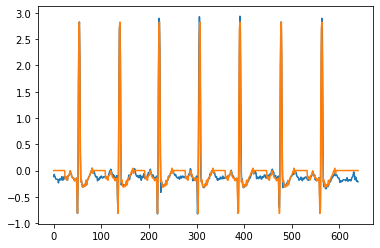

In [52]:
patient_signal = patient_record.extract_channel(0)[168960:168960 + 640]
compls = extract_all_compls(patient_signal, [54, 139, 222, 307, 391, 478, 563])
synthetic_signal = construct_signal(compls[0], [54, 139, 222, 307, 391, 478, 563])
plt.plot(patient_signal)
plt.plot(synthetic_signal)
plt.show()

Experiment: 1
Patient Record: 16265
Sample From: 153600
Target Peaks: (8, 93, 178, 262, 347, 431, 520, 613)
Adversary Errors Without SEAM: 58
Adversary Errors With SEAM: 17

Experiment: 2
Patient Record: 16265
Sample From: 168960
Target Peaks: (54, 139, 222, 307, 391, 478, 563)
Adversary Errors Without SEAM: 27
Adversary Errors With SEAM: 21

Experiment: 3
Patient Record: 16265
Sample From: 184320
Target Peaks: (10, 90, 171, 251, 333, 418, 503, 590)
Adversary Errors Without SEAM: 47
Adversary Errors With SEAM: 19

Experiment: 4
Patient Record: 16265
Sample From: 199680
Target Peaks: (24, 115, 209, 305, 405, 501, 597)
Adversary Errors Without SEAM: 69
Adversary Errors With SEAM: 24

Experiment: 5
Patient Record: 16265
Sample From: 215040
Target Peaks: (35, 127, 217, 309, 400, 494, 589)
Adversary Errors Without SEAM: 54
Adversary Errors With SEAM: 15

Experiment: 6
Patient Record: 16265
Sample From: 230400
Target Peaks: (27, 115, 200, 294, 384, 482, 575)
Adversary Errors Without SEAM: 60